In [1]:
import json
import csv
import ast
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from datetime import date, datetime
import time
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment import SentimentIntensityAnalyzer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
import statistics
sentiment = SentimentIntensityAnalyzer()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


# Import Files

In [2]:
df_clean_cat_bcovid = pd.read_csv(r'../../../Data/Scrapping/Reddit/eda/df_clean_cat_bcovid.csv')
df_clean_cat_acovid = pd.read_csv(r'../../../Data/Scrapping/Reddit/eda/df_clean_cat_acovid.csv')

df = pd.read_csv('../../../Data/Scrapping/Reddit/Twitter_Data.csv')

In [54]:
df_clean_cat_all = pd.concat([df_clean_cat_bcovid,df_clean_cat_acovid], axis = 0)

In [45]:
df_clean_cat_all

,text,author,date,score,category,sentiment
0,i understand some people here seem to miss the...,['c8jogr'],03/07/2019,1218,taxi,Positive
1,"so on my way back home, my taxi broke down, i ...",['btvmeg'],28/05/2019,1151,taxi,Negative
2,taxi touting at ion orchard,['a9t97u'],27/12/2018,502,taxi,Neutral
3,23yo edgelord throws $1000 in taxi driver's fa...,['8cfad6'],15/04/2018,399,taxi,Neutral
4,"kathy was a ‘people person’, loved by many: fa...",['8dwlb2'],21/04/2018,357,taxi,Positive
...,...,...,...,...,...,...
10291,some of these bus drivers scare the crap out o...,['Ikamochi'],20/03/2021,-78,bus,Negative
10292,how the hell cannot speak english can become b...,['Juwae'],05/09/2020,-78,bus,Neutral
10293,how the turn busses have turned.,['postmateDumbass'],11/07/2021,-85,bus,Neutral
10294,those lorries are driven by migrant workers th...,['GlobalSettleLayer'],23/04/2021,-97,bus,Positive


# Train data to identify sentitments with Twitter data

## Clean the twitter data

In [4]:
# drop missing rows
df.dropna(axis=0, inplace=True)

# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [5]:
import re    # RegEx for removing non-letter characters

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *


def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivyha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Train data

In [6]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [7]:
# Convert categorical variable into dummy/indicator variables.
y = pd.get_dummies(df['category'])
# Train and Test split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Extracting validation set from the train set
valid_size=1000
X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_valid.shape, y_valid.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (114078, 50) (114078, 3)
Validation Set -> (1000, 50) (1000, 3)
Test Set -> (113078, 50) (113078, 3)


In [8]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val*100

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall

vocab_size = 5000
embedding_size = 32

# Build model
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

print(model3.summary())

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model
num_epochs = 1
batch_size = 32
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs)

# Evaluate model on the test set
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('CNN + LSTM Accuracy  : {:.2f}'.format(100 * accuracy), '%')
print('CNN + LSTM Precision : {:.2f}'.format(100 * precision), '%')
print('CNN + LSTM Recall    : {:.2f}'.format(100 * recall), '%')
print('CNN + LSTM F1 Score  : {:.2f}'.format(f1_score(precision, recall)), '%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [10]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Shuffle data, not really necesary, just for healthy practice
df_slice = df.sample(frac=1.0).reset_index(drop=True)

# Create prediction column based on Polarity Score
# -1: Negative Compound Scores
# 1: Positive Compound Scores
df_slice['Prediction'] = df_slice['clean_text'].apply(lambda x: 1 if sia.polarity_scores(x)['compound'] >= 0.5 else(-1 if sia.polarity_scores(x)['compound'] <= -0.5  else 0))

# Edit category column: 1 for positive, -1 or Negative , 0 for Neutral
df_slice['category'] = df_slice['category'].apply(lambda x: -1 if x == "Negative" else(1 if x == "Positive" else 0))

# Check if Category and prediction column match for accuracy calculation
df_slice['Accuracy'] = df_slice.apply(lambda x: 1 if x[1] == x[2] else 0, axis = 1)

# Create confusion matrix
def conf_matrix(x):
    if x[1] == 1 and x[2] == 1:
        return 'TP'
    elif x[1] == 1 and x[2] == -1:
        return 'FN'
    elif x[1] == -1 and x[2] == 1:
        return 'FP'
    elif x[1] == -1 and x[2] == -1:
        return 'TN'
    else:
        return 0

df_slice['Conf_Matrix'] = df_slice.apply(lambda x: conf_matrix(x), axis = 1)
df_slice.tail(10)


conf_vals = df_slice.Conf_Matrix.value_counts().to_dict()
print(conf_vals)

accuracy = (conf_vals['TP'] + conf_vals['TN']) / (conf_vals['TP'] + conf_vals['TN'] + conf_vals['FP'] + conf_vals['FN'])
precision = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FP'])
recall = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FN'])
score = f1_score(precision, recall)
print('Accuracy: ', round(100 * accuracy, 2),'%',
      '\nPrecision: ', round(100 * precision, 2),'%',
      '\nRecall: ', round(100 * recall, 2),'%',
      '\nF1 Score: ', round(score, 2),'%')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ivyha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{0: 110064, 'TP': 30429, 'TN': 12359, 'FN': 6432, 'FP': 3685}
Accuracy:  80.88 % 
Precision:  89.2 % 
Recall:  82.55 % 
F1 Score:  85.75 %


# Create LSTM Function for Sentiment Analysis

In [11]:
# from keras.models import load_model

# # Load model
# model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model3.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    # Print('The predicted sentiment is', sentiment_classes[yt[0]])  
    return sentiment_classes[yt[0]]

In [12]:
def sentiment_text(df):
    sent = []

    #for post in data:
    #    for com in post['comments']:
    #        r = predict_class([com['comment']])
    #        post['sentiment'] = r
    #        sent.append(r)
    
    for t in df['text']:
        #r = 
        sent.append(predict_class([t]))

    df['sentiment'] = sent      

# Sentiment of Post

In [13]:
sentiment_text(df_clean_cat_bcovid)
sentiment_text(df_clean_cat_acovid)

In [55]:
sentiment_text(df_clean_cat_all)

# Visualize Sentiment

## Sentiment Before Covid

### Bus

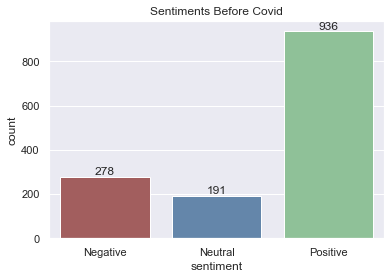

In [14]:
#df_clean_cat_bcovid.groupby('sentiment').count().plot(kind='bar')

sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'bus'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments Before Covid')
sns.color_palette('pastel')

for container in ax.containers:
    ax.bar_label(container)


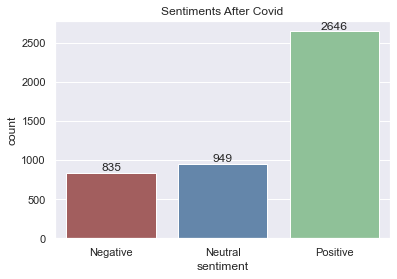

In [15]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'bus'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments After Covid')

for container in ax.containers:
    ax.bar_label(container)

### MRT

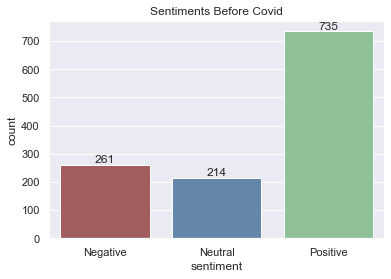

In [16]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'mrt'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments Before Covid')

for container in ax.containers:
    ax.bar_label(container)

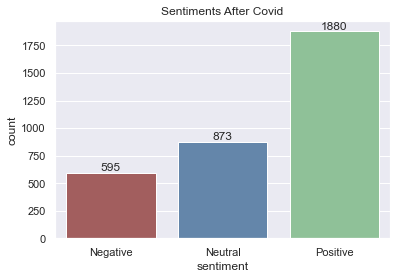

In [17]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'mrt'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments After Covid')

for container in ax.containers:
    ax.bar_label(container)

### Taxi

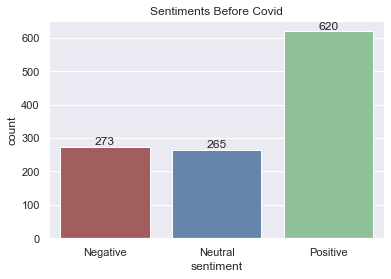

In [18]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'taxi'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments Before Covid')

for container in ax.containers:
    ax.bar_label(container)

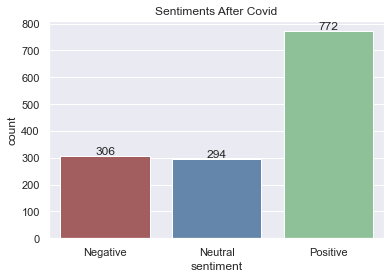

In [19]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'taxi'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments After Covid')

for container in ax.containers:
    ax.bar_label(container)

### Private Hire

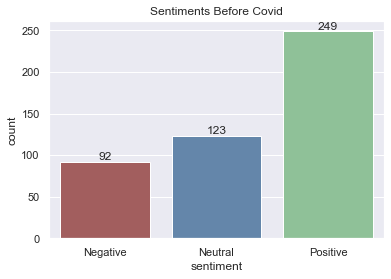

In [20]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'private hire'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments Before Covid')

for container in ax.containers:
    ax.bar_label(container)

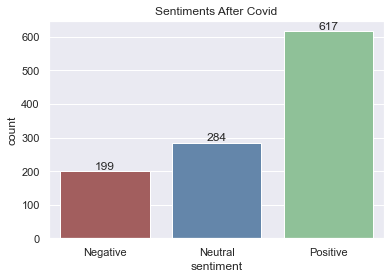

In [21]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'private hire'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments After Covid')

for container in ax.containers:
    ax.bar_label(container)

### Car Rental

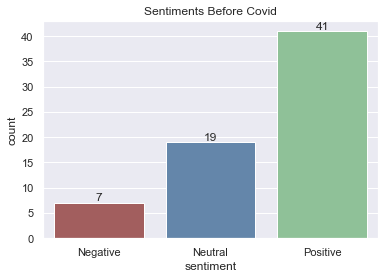

In [22]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'car rental'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments Before Covid')

for container in ax.containers:
    ax.bar_label(container)

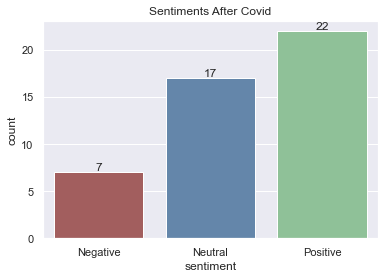

In [23]:
sns.set_theme(style = 'darkgrid')
ax = sns.countplot(x = 'sentiment', data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'car rental'],
                   order = ['Negative', 'Neutral', 'Positive'], palette = ['#ad5353', '#5985b5', '#87c993'])
ax.set_title('Sentiments After Covid')

for container in ax.containers:
    ax.bar_label(container)

# Preview Negative Post & Comments

In [24]:
def wc_neg(data, stopword, cat):
    t = data[data['sentiment']=='Negative']
    p = t[t['category'] == cat]

    message = p['text'].tolist()
    
    text = " ".join(list(message))

    wc = WordCloud(stopwords = stopword, background_color='white').generate(text)

    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    print('\n') 

In [53]:
def df_wc_no_stopwords(data, stopwords):
    output = []
    output_df = data
    #t = data[data['sentiment']=='Negative']
    #p = t[t['category'] == cat]
    
    for text in data['text']:
        s_text = text.split()
        result_text = [word for word in s_text if word.lower() not in stopwords]
        result = ' '.join(result_text)
        output.append(result)

    output_df['text'] = pd.Series(output)

    return output_df

In [26]:
stopwords = set(STOPWORDS)
stopwords.update(['mrt', 'station', 'see', 'bus', 'buses', 'line', 'account', 'one', 'full',
                  'get', 'min', 'class', 'year', 'pm', '', 'take', 'taxi', 'allow', 'last', 'almost',
                  'post', 'start', 'cross', 'car_rental', 'comfortdelgro', 'singapore', 'grab',
                  'night', 'find', 'need', 'build', 'photo', 'video', 'leave', 'car', 'train', 
                  'think', 'food', 'make', 'set', 'fresh', 'sbs', 'driver', 'delgro', 'comfort',  
                  'move',  'ever', 'blue', 'uber', 'go', 'look', 'use', 'also', 'give', 
                  'many', 'come', 'lot', 'seem', 'guess', 'definitely', 'sure', 'keep', 'much', 'already', 
                  'do', 'lol', 'people', 'well', 'back', 'week', 'u', 'want', 'day', 'will', 'know', 
                  'even', 'really', 'said', 'say', 'cab', 'public transport', 'taxis', 'public', 
                  'transport', 'thing', 'still', 'got', 'now', 's', 'stop', 'around', 'another', 'stations',
                  'smrt', 'next', 'us', 'may', 'person', 'years', 'going', 'trains', 'way', 'etc', 'makes',
                  'seat', 'guy', 'https', 'always', 'riders', 'cabbie', 'sg', 'drivers', 'auntie', 'man', 
                  'uncle', 'stops', 'someone', 'something', 'andy', 'cabs', 'cabbies', 'order', 'delivery', 
                  'gojek', 'quite','fucking', 'every', 'getting', 'trying', 'told', 'something', 'singaporean', 
                  'feel', 'lta', 'fuck', 'without', 'let', 'made', 'getting', 'passenger', 'restaurant', 'grabfood', 'door', 
                  'merchant', 'don', 't', 'customer', 'cars', 'actually', 'senior', 'entrepreneur', 'rental', 'cars', 'current'])


### Bus

===========================Bus Before Covid Title===========================
prc missed her stop and demands bus driver to u-turn back by getting down and blocking the bus
almost every sentence of hers reeks of self-entitlement. everything is about her. but she failed to realise that she is holding up the bus driver, and many other ‘innocent’ passengers. quite keen to know what happens to her.
i'm very surprised that none of the passengers on that bus was a very tired just-after-ot person that just wanted to go home and went "wtf is this hold up?" and checked on it before finding out it's literally one fucking entitled bitch and just shoved her out of the way. where's all the passive aggressive aunties/uncles when you need them?
bad placement of bus stop and taxi stand?
saw this on "fabrications about the pap" fb account. "this happened in bus number 43. this prc woman started making noise from the paya lebar mrt bus stop till the tai seng bus stop. initially, i dunno for what reason (

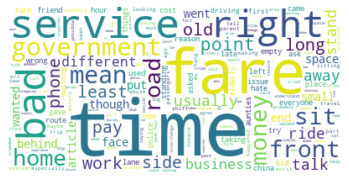

In [27]:
t = df_clean_cat_bcovid[df_clean_cat_bcovid['sentiment']=='Negative']
p = t[t['category'] == 'bus']

print('===========================Bus Before Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_bcovid, stopwords, 'bus')

===========================Bus After Covid Title===========================
tried my hand at editing this shot of an empty upper deck of a bus to give off a sinister/apocalyptic vibe
it was hit by another bus, then knocked over the railings and fell over the other side. seems like there are passengers on the bus too. praying that no one is badly injured...
i am a bus captain. it is rly a very difficult and painful situation now. measures have tightened, so now we eat alone, smoke alone, have our break alone. lots of the normal day-to-day interaction are being cut down, and now i can go an entire 10-hr shift without speaking to anyone. its very lonely. while i try to keep things upbeat, there is one thing that really broke my heart --- once there was a karen who asked a lot of questions and very difficult to deal with. i kept my cool and dealt with it. and few days later, another passenger on that same bus wrote in and complained me for being irresponsible to "chit chat" with that karen

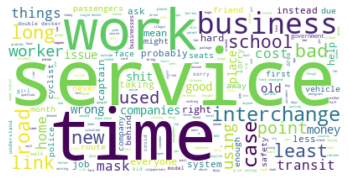

In [28]:
t = df_clean_cat_acovid[df_clean_cat_acovid['sentiment']=='Negative']
p = t[t['category'] == 'bus']

print('===========================Bus After Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_acovid, stopwords, 'bus')

### MRT

===========================MRT Before Covid Title===========================
auntie forces mrt door open and gets herself stuck at little india. insane strength/10
so this idiot is the reason why my train is delayed?
does anyone else prefer previous mrt train with no digital screen?
she could have died if the door on station side closed and train moved off like it did in a similar incident in seoul.
> the smrt (other than constantly hearing homer simpson ringing in my head all day) is a shining example to everyone of what mass transit systems should be. be careful. anytime someone compliments the system publicly it breaks down. edit: [congratulations, you've made the the entire ewl suffer a power failure. this is a dangerous game /u/oddsuzy](https://www.reddit.com/r/singapore/comments/6pbqhz/ewl_train_delayed_due_to_power_failure_from_pasir/)


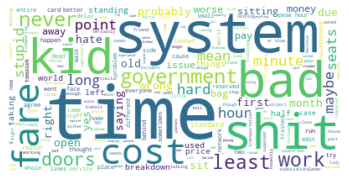

In [29]:
t = df_clean_cat_bcovid[df_clean_cat_bcovid['sentiment']=='Negative']
p = t[t['category'] == 'mrt']

print('===========================MRT Before Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_bcovid, stopwords, 'mrt')

===========================MRT After Covid Title===========================
current mrt map but with dark mode
our foreign workers resting on asphalt before working on our mrt lines. let's be grateful!
challenge accepted. 122 mrt stations rta (single-entry/exit) 6h59m30s
list of confusing and wrong singapore's mrt station names
2040 mrt map but with dark mode, (again)


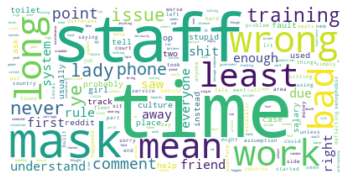

In [30]:
t = df_clean_cat_acovid[df_clean_cat_acovid['sentiment']=='Negative']
p = t[t['category'] == 'mrt']

print('===========================MRT After Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_acovid, stopwords, 'mrt')

### Taxi

===========================Taxi Before Covid Title===========================
so on my way back home, my taxi broke down, i walked the highway, and a random uncle offered to send me back! :')
sounds like complete bullshit. 1) no singaporean taxi driver wouldnt just shut up and drive when they're offered 50x the fare 2) 999 will not bother explaining whether grab is a contract or not, their aim is to dispatch someone and get time wasting idiots like him off the phone so someone else who actually needs proper help can get through. 3) he would have gotten arrested for swearing at a public servant. 4) if someone was gonna lose 70k for missing a meeting he would have used the 70k to buy a car and not taken a fucking comfort cab booked over grab.
license plate and other details, send to lta and the cab company
beating "change shift" taxis drivers at game
what does this goat man thing mean in the back of a taxi cab?


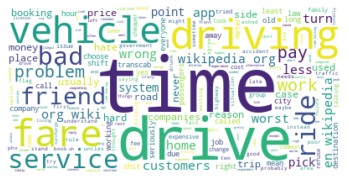

In [31]:
t = df_clean_cat_bcovid[df_clean_cat_bcovid['sentiment']=='Negative']
p = t[t['category'] == 'taxi']

print('===========================Taxi Before Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_bcovid, stopwords, 'taxi')

===========================Taxi After Covid Title===========================
kids, a long time ago we had sbs taxi. and crown was the way to travel.
played too much crazy taxi
grab's purpose was to force competition. remember the days when paying for cab fare with card always cost extra? now that comfort has upped their game, i don't use grab anymore.
elderly man dies after allegedly being dragged by taxi for 30m
i deleted my grab app late last year. i hailed a cdg taxi on the street yesterday. i paid with my cdg app, using the "pay for street hail" button. i was rewarded with a $3 polar voucher. not bad for a $10 fare.


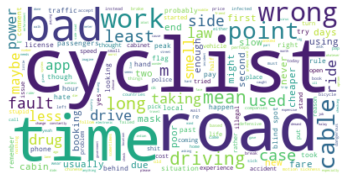

In [32]:
t = df_clean_cat_acovid[df_clean_cat_acovid['sentiment']=='Negative']
p = t[t['category'] == 'taxi']

print('===========================Taxi After Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_acovid, stopwords, 'taxi')

### Private Hire

===========================Taxi Before Covid Title===========================
when you pay a metered fee, you have interest to want the cheapest (fastest shortest) route, and prevent the driver from bringing you on a long road trip about singapore. passenger say > driver. when you pay a flat fee, the driver have interest to get there asap, failure to do so would net him negative opportunity cost. driver needs to prevent passenger from going on a tour around singapore. driver say > passenger. justgrab is a flat fee service... i feel odd to explain “the obvious”.
does anyone else hate grabfood? i don't understand how they can suck so bad, between getting the kitchen to accept and order vs finding a dispatch rider? deliveroo is better in every other way.
i have been reading up on some pretty iffy stuff happening in uber sg https://medium.com/@harison.p.tucosic/after-knowingly-leasing-recalled-cars-in-singapore-tough-questions-for-the-smart-folks-at-uber-f78d4b3111b7. seems like uber sg/se

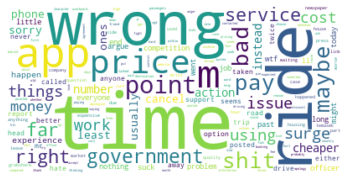

In [33]:
t = df_clean_cat_bcovid[df_clean_cat_bcovid['sentiment']=='Negative']
p = t[t['category'] == 'private hire']

print('===========================Taxi Before Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_bcovid, stopwords, 'private hire')

===========================Taxi After Covid Title===========================
grab rewards excels at being pathetic with rewarding members. $2 off for 1300 points. rewards 1.5 points per $1 spent. averaging $860 just to receive $2 off.
coming to you live from the scene: i just booked a ride from punggol to dakota for $12.40 vs grab's $14.30. also, psa that comfort app doesn't charge admin fees for cc payment. fuck grab.
fuck grab, take gojek/comfort/tada/zig
if there are empty seats just grab one. don't need to feel awkward. if you're standing, can leave your bags on the floor, but i don't recommend sitting on the floor.
this just happened to my friends in their grab ride home. no one, singaporean or not, deserves to be treated like this especially when you’re in a vulnerable position like being in some strangers vehicle… also wtf does eating at ya kun have to do with being singaporean?! i have friends born and raised here who’ve never set foot in one…


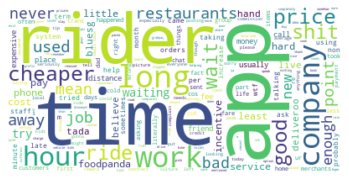

In [34]:
t = df_clean_cat_acovid[df_clean_cat_acovid['sentiment']=='Negative']
p = t[t['category'] == 'private hire']

print('===========================Taxi After Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_acovid, stopwords, 'private hire')

### Car Rental

===========================Private Hire Before Covid Title===========================
man who drove rental car illegally pleads guilty to causing the death of motorcycle pillion rider
for those too lazy to get past the paywall: >rental firms stepping up checks as their vehicles are being hired to smuggle contraband cigarettes and drugs zaihan mohamed yusof rental companies said they are increasingly concerned that some of their cars are being hired for criminal activities. not only are the cars impounded during investigation, but some are also damaged during an arrest. >between 2014 and last year, the central narcotics bureau (cnb) detained more than 70 rental vehicles for investigations. >the latest case involving a rental car was on jan 13, when police chased a honda fit for 5km before the driver and passenger were arrested for a drug-related offence. >those in the car rental trade said the problem is fairly common. >mr elvin ang, 32, a co-director of elitez car rental, said: "i've s

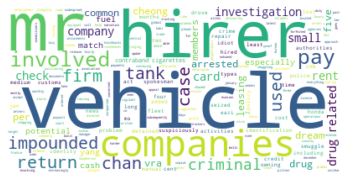

In [35]:
t = df_clean_cat_bcovid[df_clean_cat_bcovid['sentiment']=='Negative']
p = t[t['category'] == 'car rental']

print('===========================Private Hire Before Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_bcovid, stopwords, 'car rental')

===========================Private Hire After Covid Title===========================
former senior minister of state for transport lam pin min joins car rental firm lumens as senior adviser
nothing wrong with an entrepreneur hawking his wares, but that instagram with motivation quotes and formal wear is a dead giveaway. real entrepreneurs don’t need to pose in suits, ties and flashy rental cars so it’s probably some mlm getting you to sign up
>cutting one lane on either side makes it very bike/pmd/pma friendly, mitigates the effect it has on current car traffic, and it will incentivize pmd/bike adoption instead of cars. traffic in amk is generally congested and terrible. especially during peak hours. cutting down lanes is not a feasible idea.
older cars have less safety features compared to current cars. the safety features like crumple zones and airbags take up quite a bit of space.
i'd suggest that you go ahead and get that licence. owning a car may be expensive, but renting one isn'

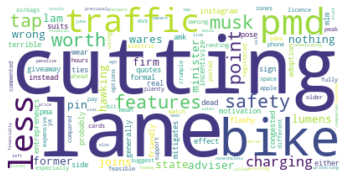

In [36]:
t = df_clean_cat_acovid[df_clean_cat_acovid['sentiment']=='Negative']
p = t[t['category'] == 'car rental']

print('===========================Private Hire After Covid Title===========================')
for index,row in p[:5].iterrows():
    print(row['text'])
wc_neg(df_clean_cat_acovid, stopwords, 'car rental')

# Export sentiment data

In [37]:
df_clean_cat_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_bcovid_sent.csv', index = False)
df_clean_cat_acovid.to_csv(r'../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_acovid_sent.csv', index = False)

# Export data needed for Dashboard

In [38]:
def sentiment_freq(df, cat):
    df_freq = df[df['category'] == cat].groupby('sentiment').size()
    df_freq = pd.DataFrame(df_freq)
    return df_freq.reset_index(level = ['sentiment'])

In [39]:
df_clean_bus_acovid_table = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'bus'].groupby('sentiment').size()
df_clean_bus_acovid_table = pd.DataFrame(df_clean_bus_acovid_table)
df_clean_bus_acovid_table.reset_index(level=['sentiment'])

,sentiment,0
0,Negative,835
1,Neutral,949
2,Positive,2646


In [40]:
df_bus_bcovid_freq_export = sentiment_freq(df_clean_cat_bcovid, 'bus')
df_mrt_bcovid_freq_export = sentiment_freq(df_clean_cat_bcovid, 'mrt')
df_taxi_bcovid_freq_export = sentiment_freq(df_clean_cat_bcovid, 'taxi')
df_privatehire_bcovid_freq_export = sentiment_freq(df_clean_cat_bcovid, 'private hire')
df_crental_bcovid_freq_export = sentiment_freq(df_clean_cat_bcovid, 'car rental')

df_bus_acovid_freq_export = sentiment_freq(df_clean_cat_acovid, 'bus')
df_mrt_acovid_freq_export = sentiment_freq(df_clean_cat_acovid, 'mrt')
df_taxi_acovid_freq_export = sentiment_freq(df_clean_cat_acovid, 'taxi')
df_privatehire_acovid_freq_export = sentiment_freq(df_clean_cat_acovid, 'private hire')
df_crental_acovid_freq_export = sentiment_freq(df_clean_cat_acovid, 'car rental')

In [41]:
df_bus_bcovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_bus_bcovid_freq_export.csv', index = False, header = True)
df_mrt_bcovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_mrt_bcovid_freq_export.csv', index = False, header = True)
df_taxi_bcovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_taxi_bcovid_freq_export.csv', index = False)
df_privatehire_bcovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_privatehire_bcovid_freq_export.csv', index = False)
df_crental_bcovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_crental_bcovid_freq_export.csv', index = False)

df_bus_acovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_bus_acovid_freq_export.csv', index = False)
df_mrt_acovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_mrt_acovid_freq_export.csv', index = False)
df_taxi_acovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_taxi_acovid_freq_export.csv', index = False)
df_privatehire_acovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_privatehire_acovid_freq_export.csv', index = False)
df_crental_acovid_freq_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_crental_acovid_freq_export.csv', index = False)

In [42]:
export_wc_neg_bus_bcovid = df_wc_neg_no_stopwords(df_clean_cat_bcovid, stopwords, 'bus')
export_wc_neg_mrt_bcovid = df_wc_neg_no_stopwords(df_clean_cat_bcovid, stopwords, 'mrt')
export_wc_neg_taxi_bcovid = df_wc_neg_no_stopwords(df_clean_cat_bcovid, stopwords, 'taxi')
export_wc_neg_privatehire_bcovid = df_wc_neg_no_stopwords(df_clean_cat_bcovid, stopwords, 'private hire')
export_wc_neg_crental_bcovid = df_wc_neg_no_stopwords(df_clean_cat_bcovid, stopwords, 'car rental')

export_wc_neg_bus_acovid = df_wc_neg_no_stopwords(df_clean_cat_acovid, stopwords, 'bus')
export_wc_neg_mrt_acovid = df_wc_neg_no_stopwords(df_clean_cat_acovid, stopwords, 'mrt')
export_wc_neg_taxi_acovid = df_wc_neg_no_stopwords(df_clean_cat_acovid, stopwords, 'taxi')
export_wc_neg_privatehire_acovid = df_wc_neg_no_stopwords(df_clean_cat_acovid, stopwords, 'private hire')
export_wc_neg_crental_acovid = df_wc_neg_no_stopwords(df_clean_cat_acovid, stopwords, 'car rental')

In [56]:
df_clean_cat_all_export = df_wc_no_stopwords(df_clean_cat_all, stopwords)

In [60]:
df_clean_cat_all_export.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/df_clean_cat_all_export.csv', index = False)

In [59]:
df_clean_cat_all_export['text']

0        understand miss old taxis, found picture took ...
1        home, broke down, walked highway, random offer...
2                                      touting ion orchard
3        23yo edgelord throws $1000 driver's face proce...
4        kathy ‘people person’, loved many: family, fri...
                               ...                        
10291                 interesting good routes sightseeing?
10292    happened 2 months ago. sitting second floor lo...
10293    scary... 56yo woman wearing revealing shorts s...
10294    pasir ris-punggol. surely rid 'memorable' inte...
10295    story reminds time school. lady walks mutters ...
Name: text, Length: 14600, dtype: object

In [43]:
# export_wc_neg_bus_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_bus_bcovid.csv', index = False)
# export_wc_neg_mrt_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_mrt_bcovid.csv', index = False)
# export_wc_neg_taxi_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_taxi_bcovid.csv', index = False)
# export_wc_neg_privatehire_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_privatehire_bcovid.csv', index = False)
# export_wc_neg_crental_bcovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_crental_bcovid.csv', index = False)

# export_wc_neg_bus_acovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_bus_acovid.csv', index = False)
# export_wc_neg_mrt_acovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_mrt_acovid.csv', index = False)
# export_wc_neg_taxi_acovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_taxi_acovid.csv', index = False)
# export_wc_neg_privatehire_acovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_privatehire_acovid.csv', index = False)
# export_wc_neg_crental_acovid.to_csv(r'../../../Data/Scrapping/Reddit/dashboard data/export_wc_neg_crental_acovid.csv', index = False)